## Evaluations using the "super" dataset, to plot some dependencies on exponents, models or noise

#### Here for classification

In [1]:
#imports
import numpy as np
import torch
from swag.posteriors import swag as swag
from tqdm import tqdm

from load_andi_dataset import *
from LSTM_Neural_Network import *
from swag_lr_scheduler import *

from matplotlib import pyplot as plt

In [2]:
#configer to only use gpu 1 not 0!
import os

if torch.cuda.is_available():
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# Device configuration, run on gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dim = 1#2
# Hyper-parameters, neuralnet parameters need to match the loaded model! 
input_dim = dim # 1D input sequence
LSTM_size = [128,128,64]
hidden_size = 20
output_dim = 5 #output size
batch_size = 500

number_swags = 5 #number of swag models in multi swag ensemble
number_mc_samples = 10 #number of samples taken per swag model

In [4]:
#setup data using saved trajectories
T = 100#500#100
noise_T = T
N_test = 100000
N_save = 2000
task = 2
use_increments = True

test_path = f"datasets/trajectories/{dim}d/validset/"
if dim == 1:
    test_path = f"datasets/trajectories/validset/"
super_dataset = AnDi_super_dataset_from_saved_trajs(path = test_path, task = task, dim = dim, N_total = N_test, 
                                              T = T, N_save = N_save, use_increments = use_increments)
print(len(super_dataset))
#loader
super_loader = torch.utils.data.DataLoader(dataset=super_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Creating a dataset for task(s) [2] and dimension(s) [1].
Generating dataset for dimension 1.
100000


In [5]:
#check dataset example
ex_models,ex_exponents,ex_noise,ex_traj = iter(super_loader).next()
print(ex_models[0],ex_exponents[0],ex_noise[0],ex_traj[0][0:5])

tensor(1) tensor([0.2000]) tensor(0.1000) tensor([[ 3.1514],
        [ 0.2321],
        [ 0.0272],
        [-0.1448],
        [-0.0521]])


In [6]:
#load multiswag classification model:
checkpoints_path = f"saves/classi/{dim}d/{T}_lenght/multi/"
if dim == 1:
    checkpoints_path = f"saves/classi/{T}_lenght/multi/"
multi_swag_models = []
for i in range(number_swags):
    swag_model = swag.SWAG(LSTM_Classification, subspace_type = 'covariance', 
                       subspace_kwargs={'max_rank': 20}, num_input_features = input_dim, 
                       num_classes = output_dim, hidden_size = hidden_size, LSTM_size=LSTM_size)
    swag_model.to(device)
    swag_model.subspace.rank = torch.tensor(0)
    
    
    name = "swag_modelcheckpoint_multiswag%s" % i
    savefile = checkpoints_path + name
    
    swag_model.load_state_dict(torch.load(savefile,map_location=device))
    swag_model.eval()
    
    
    multi_swag_models.append(swag_model)
    
#crossentropy loss used for classification tasks and Softmax activation function
criterion = nn.CrossEntropyLoss() 
Softmax = torch.nn.Softmax(dim=1)

In [7]:
#test multi swag model
classes = ['attm', 'ctrw', 'fbm', 'lw', 'sbm']
#plotting accuracy over confidence
confidence = torch.arange(0,1,0.05).to(device) #confidence intervals
accuracy_interval = torch.zeros(len(confidence)).to(device) #accuracy in each confidence interval
n_interval = torch.zeros(len(confidence)).to(device) #number of samples for each confidence interval

alpha_interval = torch.arange(0.05,2,0.1).to(device)
acc_per_alpha = torch.zeros(len(alpha_interval)).to(device)
pred_acc_per_alpha = torch.zeros(len(alpha_interval)).to(device)
n_per_alpha = torch.zeros(len(alpha_interval)).to(device)

acc_per_noise = torch.zeros(3).to(device) #acc per noise beeing 0.1,0.5,1
n_per_noise = torch.zeros(3).to(device)
confidence_per_noise = torch.zeros(3).to(device)

all_gt_models = np.array([])
all_confidences = np.array([])
all_exponents = np.array([])
all_noises = np.array([])



with torch.no_grad():
    
    n_test_steps = len(super_loader)
    n_correct = 0
    n_samples = 0
    acc_loss = 0
    #acc_pred_var = 0
    n_class_truepositive = np.zeros(output_dim)
    n_class_falsepositive = np.zeros(output_dim)
    n_class_falsenegative = np.zeros(output_dim)
    conf_matrix = np.zeros((output_dim,output_dim))
    
    for labels, exponents, noise, traj in tqdm(super_loader):
        all_gt_models = np.append(all_gt_models,labels)
        all_exponents = np.append(all_exponents,exponents)
        all_noises = np.append(all_noises,noise)
        
        traj = traj.to(device)
        labels = labels.to(device)
        exponents = exponents.to(device)
        noise = noise.to(device)
        
        output_samples = torch.ones(number_mc_samples*number_swags, len(traj), output_dim, dtype=torch.float32).to(device) 
        output_samples_prob = torch.ones(number_mc_samples*number_swags, len(traj), output_dim, dtype=torch.float32).to(device)
        
        for k in range(number_swags):
            for i in range(number_mc_samples):
                multi_swag_models[k].sample()
                output_samples[i+k*number_mc_samples] = multi_swag_models[k](traj)
                output_samples_prob[i+k*number_mc_samples] = Softmax(output_samples[i+k*number_mc_samples])
        
        outputs = output_samples.mean(0)
        outputs_prob = output_samples_prob.mean(0)
        #outputs_var = output_samples.var(0)
        
        #acc_pred_var += outputs_var.sum().item()
        all_confidences = np.append(all_confidences,outputs_prob.to("cpu").detach().numpy())
            
        acc_loss += criterion(outputs, labels.view(-1)).item()
        
        _, predicted = torch.max(outputs_prob.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted.view(-1) == labels.view(-1)).sum().item()
        
    accuracy = n_correct/n_samples
    mean_loss = acc_loss/n_test_steps
    #mean_pred_var = acc_pred_var/n_samples
    print(f'Accuracy of the network on the 10000 test trajectories: {accuracy*100}%')
    print(f'Mean loss is: {mean_loss}')

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:46<00:00,  4.26it/s]

Accuracy of the network on the 10000 test trajectories: 44.879000000000005%
Mean loss is: 1.2190670961141585


In [8]:
all_gt_models
print(all_confidences)
print(all_confidences[0]+all_confidences[1]+all_confidences[2]+all_confidences[3]+all_confidences[4])
all_exponents
all_noises
all_confidences = all_confidences.reshape(100000,5)
print(sum(all_confidences[2]))
print(all_confidences[0])
plotdata = np.asarray([all_gt_models,all_confidences[:,0],all_confidences[:,1],all_confidences[:,2],all_confidences[:,3],all_confidences[:,4],all_exponents,all_noises])
print(plotdata)
print(f"done {T}")
savename = "plotdata/"+f"{dim}d_classification_length{T}"
if dim  == 1:
    savename = "plotdata/"+f"classification_length{T}"
np.savetxt(savename,plotdata)

[2.74495453e-01 7.25104630e-01 1.04829349e-04 ... 2.55500495e-01
 8.40612203e-02 2.61290461e-01]
0.9999999794326868
0.9999999925494194
[2.74495453e-01 7.25104630e-01 1.04829349e-04 2.95806476e-05
 2.65486800e-04]
[[1.00000000e+00 1.00000000e+00 2.00000000e+00 ... 2.00000000e+00
  0.00000000e+00 2.00000000e+00]
 [2.74495453e-01 4.36530143e-01 2.93075264e-01 ... 2.05752581e-01
  1.49572194e-01 2.26571560e-01]
 [7.25104630e-01 5.47837675e-01 1.36475965e-01 ... 3.09181772e-02
  3.34526122e-01 1.72576278e-01]
 ...
 [2.65486800e-04 1.03825042e-02 2.93116152e-01 ... 3.14254194e-01
  2.11854771e-01 2.61290461e-01]
 [2.00000003e-01 4.49999988e-01 1.60000002e+00 ... 1.95000005e+00
  8.00000012e-01 4.00000006e-01]
 [1.00000001e-01 1.00000001e-01 1.00000001e-01 ... 1.00000000e+00
  5.00000000e-01 5.00000000e-01]]
done 10


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

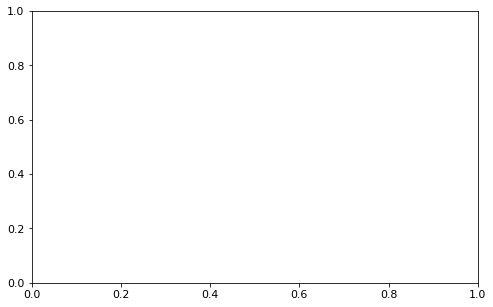

In [9]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)  

plt.plot(alpha_interval+0.05,acc_per_alpha*100,"o-",linewidth=0.7,label="observed")
plt.plot(alpha_interval+0.05,pred_acc_per_alpha*100,"o-",linewidth=0.7,label="predicted")


plt.xlabel("Ground Truth Anomalous Exponent")
plt.ylabel("Accuracy %")
plt.legend()

#use fitting save directory!
#plt.savefig("figs/super_evaluate/class_acc_over_exp_all_models_predicted.png")
#plt.savefig("figs/super_evaluate/class_acc_over_exp_all_models_predicted.svg")

#plt.savefig("figs/super_evaluate/correctnoise/class_acc_over_exp_all_models_predicted.png")
#plt.savefig("figs/super_evaluate/correctnoise/class_acc_over_exp_all_models_predicted.svg")

plt.show()

In [ ]:
snr = [10,2,1]
x_labels = ["SNR 10", "SNR 2", "SNR 1"]
x_val = [0,1,2]

plt.plot(x_val,acc_per_noise*100,"o",ms = 11,label="Observed")
plt.plot(x_val,confidence_per_noise*100,"o",ms = 11,label="Predicted")
plt.xticks(ticks = x_val, labels = x_labels, size = 16)
print(acc_per_noise)
print(confidence_per_noise)
plt.ylabel("Accuracy %")
plt.legend()


#use fitting save directory!
#plt.savefig("figs/super_evaluate/class_acc_over_noise_all_models.png")
#plt.savefig("figs/super_evaluate/class_acc_over_noise_all_models.svg")

#plt.savefig("figs/super_evaluate/correctnoise/class_acc_over_noise_all_models.png")
#plt.savefig("figs/super_evaluate/correctnoise/class_acc_over_noise_all_models.svg")

plt.show()

In [ ]:
plt.plot(confidence+0.025,accuracy_interval,"o-")
#plt.plot(confidence,accuracy_interval_multiswa,"ro-")
plt.plot(np.arange(0,1.05,0.05),np.arange(0,1.05,0.05),"grey")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")

#plt.savefig("figs/super_evaluate/conf_acc_all_models.png")
#plt.savefig("figs/super_evaluate/conf_acc_all_models.svg")

### Classifcation fbm and sbm only

In [ ]:
#imports
import numpy as np
import torch
from swag.posteriors import swag as swag
import tqdm

%run load_andi_dataset.ipynb
%run LSTM_Neural_Network.ipynb
%run swag_lr_scheduler.ipynb

In [ ]:
# Device configuration, run on gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters, neuralnet parameters need to match the loaded model! 
input_dim = 1 # 1D input sequence
LSTM_size = 64
hidden_size = 20
output_dim = 5 #output size
batch_size = 500

number_swags = 5 #number of swag models in multi swag ensemble
number_mc_samples = 10 #number of samples taken per swag model

In [ ]:
#dataset
super_dataset = AnDi_super_dataset(path = "datasets/super/1dim_100lenght/", 
                                   fname = "andiset50000_sbmfbm.txt", dim=1)
#super_dataset = AnDi_super_dataset(path = "datasets/super/1dim_100lenght/", 
#                                   fname = "andiset50000_sbmfbm_correctnoise.txt", dim=1)

super_loader = torch.utils.data.DataLoader(dataset=super_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

In [ ]:
#load multiswag classification model:
checkpoints_path = "saves/classi/multi/highswalr/"

multi_swag_models = []
for i in range(number_swags):
    swag_model = swag.SWAG(LSTM_Classification, subspace_type = 'covariance', 
                       subspace_kwargs={'max_rank': 20}, num_input_features = input_dim, 
                       num_classes = output_dim, hidden_size = hidden_size, LSTM_size=LSTM_size)
    swag_model.to(device)
    swag_model.subspace.rank = torch.tensor(0)
    
    
    name = "swag_modelcheckpoint_multiswag%s" % i
    savefile = checkpoints_path + name
    
    swag_model.load_state_dict(torch.load(savefile,map_location=device))
    swag_model.eval()
    
    
    multi_swag_models.append(swag_model)
    
#crossentropy loss used for classification tasks and Softmax activation function
criterion = nn.CrossEntropyLoss() 
Softmax = torch.nn.Softmax(dim=1)

In [ ]:
#test multi swag model
classes = ['attm', 'ctrw', 'fbm', 'lw', 'sbm']
#plotting accuracy over confidence
confidence = torch.arange(0,1,0.05).to(device) #confidence intervals
accuracy_interval = torch.zeros(len(confidence)).to(device) #accuracy in each confidence interval
n_interval = torch.zeros(len(confidence)).to(device) #number of samples for each confidence interval

alpha_interval = torch.arange(0.05,2,0.1).to(device)
acc_per_alpha = torch.zeros(len(alpha_interval)).to(device)
pred_acc_per_alpha = torch.zeros(len(alpha_interval)).to(device)
n_per_alpha = torch.zeros(len(alpha_interval)).to(device)

acc_per_noise = torch.zeros(3).to(device) #acc per noise beeing 0.1,0.5,1
n_per_noise = torch.zeros(3).to(device)
confidence_per_noise = torch.zeros(3).to(device)


with torch.no_grad():
    
    n_test_steps = len(super_loader)
    n_correct = 0
    n_samples = 0
    acc_loss = 0
    #acc_pred_var = 0
    n_class_truepositive = np.zeros(output_dim)
    n_class_falsepositive = np.zeros(output_dim)
    n_class_falsenegative = np.zeros(output_dim)
    conf_matrix = np.zeros((output_dim,output_dim))
    
    for labels, exponents, noise, traj in tqdm.tqdm(super_loader):
        
        traj = traj.to(device)
        labels = labels.to(device)
        exponents = exponents.to(device)
        noise = noise.to(device)
        
        output_samples = torch.ones(number_mc_samples*number_swags, len(traj), output_dim, dtype=torch.float32).to(device) 
        output_samples_prob = torch.ones(number_mc_samples*number_swags, len(traj), output_dim, dtype=torch.float32).to(device)
        
        for k in range(number_swags):
            for i in range(number_mc_samples):
                multi_swag_models[k].sample()
                output_samples[i+k*number_mc_samples] = multi_swag_models[k](traj)
                output_samples_prob[i+k*number_mc_samples] = Softmax(output_samples[i+k*number_mc_samples])
        
        outputs = output_samples.mean(0)
        outputs_prob = output_samples_prob.mean(0)
        #outputs_var = output_samples.var(0)
        
        #acc_pred_var += outputs_var.sum().item()
            
            
        acc_loss += criterion(outputs, labels.view(-1)).item()
        
        #allow for sbm, fbm predictions only!
        sbm_pred = outputs_prob[:,4] > outputs_prob[:,2] 
        predicted = sbm_pred*2 + 2 #should be 2 for fbm and 4 for sbm?
        #_, predicted = torch.max(outputs_prob.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted.view(-1) == labels.view(-1)).sum().item()
        
        
        for i in range(len(traj)): #determine number of true/false negative/positives
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_truepositive[label] += 1
            else:
                n_class_falsepositive[pred] += 1
                n_class_falsenegative[label] += 1
            conf_matrix[pred,label] += 1
            
            #accuracy in the confidence interval, adjust confidence to differentiate between sbm and fbm only
            sbmfbm_prob = outputs_prob[i][pred].item()/(outputs_prob[i][2].item() + outputs_prob[i][4].item())
            index = torch.where(confidence <= sbmfbm_prob)[-1][-1]
            #print(index)
            #print(outputs_prob[i][pred])
            n_interval[index] += 1
            if (label == pred):
                accuracy_interval[index] += 1
                
            #accuracy in alpha interval
            index_alpha = torch.where(alpha_interval <= exponents[i])[-1][-1]
            n_per_alpha[index_alpha] += 1
            if label == pred:
                acc_per_alpha[index_alpha] += 1
            pred_acc_per_alpha[index_alpha] += (outputs_prob[i][pred].item()/
                                            (outputs_prob[i][2].item() + outputs_prob[i][4].item()))
                
            #accuracy per noise
            index_noise = int(2*noise[i]+0.1)
            n_per_noise[index_noise] += 1
            if label == pred:
                acc_per_noise[index_noise] += 1
            confidence_per_noise[index_noise] += (outputs_prob[i][pred].item()/
                                            (outputs_prob[i][2].item() + outputs_prob[i][4].item()))
        
    accuracy = n_correct/n_samples
    mean_loss = acc_loss/n_test_steps
    #mean_pred_var = acc_pred_var/n_samples
    print(f'Accuracy of the network on the 10000 test trajectories: {accuracy*100}%')
    print(f'Mean loss is: {mean_loss}')
    #print(f'Mean Variance predicted by SWAG is: {mean_pred_var}')
    
    class_precision = n_class_truepositive/(n_class_truepositive+n_class_falsepositive)
    class_recall = n_class_truepositive/(n_class_truepositive+n_class_falsenegative)
    class_f1_score = n_class_truepositive/(n_class_truepositive+0.5*(n_class_falsepositive+n_class_falsenegative))
    
    for i in range(output_dim):
        print(f"F1 score of class {classes[i]} is {class_f1_score[i]}")
    print(f"Mean F1 score is {class_f1_score.mean()}")


    
confidence = confidence.to("cpu")
accuracy_interval = (accuracy_interval/n_interval).to("cpu")
n_interval = n_interval.to("cpu")
alpha_interval = alpha_interval.to("cpu")
acc_per_alpha = (acc_per_alpha/n_per_alpha).to("cpu")
pred_acc_per_alpha = (pred_acc_per_alpha/n_per_alpha).to("cpu")
n_per_alpha = n_per_alpha.to("cpu")
acc_per_noise = (acc_per_noise/n_per_noise).to("cpu")
confidence_per_noise = (confidence_per_noise/n_per_noise).to("cpu")
n_per_noise = n_per_noise.to("cpu")

    
#plot confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

conf_matrix = conf_matrix/conf_matrix.sum(axis=0)


df_cm = pd.DataFrame(conf_matrix, index = [i for i in classes],
                  columns = [i for i in classes])
# plt.figure(figsize=(7,7))
#sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True)

plt.show()

In [ ]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)  

plt.plot(alpha_interval+0.05,acc_per_alpha*100,"o-",linewidth=0.7,label = "observed")
plt.plot(alpha_interval+0.05,pred_acc_per_alpha*100,"o-",linewidth=0.7, label = "predicted")


plt.xlabel("Ground Truth Anomalous Exponent")
plt.ylabel("Accuracy %")
plt.legend()

#use fitting save directory!
#plt.savefig("figs/super_evaluate/class_acc_over_exp_sbmfbm_only_predicted.png")
#plt.savefig("figs/super_evaluate/class_acc_over_exp_sbmfbm_only_predicted.svg")

#plt.savefig("figs/super_evaluate/correctnoise/class_acc_over_exp_sbmfbm_only_predicted.png")
#plt.savefig("figs/super_evaluate/correctnoise/class_acc_over_exp_sbmfbm_only_predicted.svg")

plt.show()

In [ ]:
snr = [10,2,1]
x_labels = ["SNR 10", "SNR 2", "SNR 1"]
x_val = [0,1,2]

plt.plot(x_val,acc_per_noise*100,"o",ms = 11,label="Observed")
plt.plot(x_val,confidence_per_noise*100,"o",ms = 11,label="Predicted")
plt.xticks(ticks = x_val, labels = x_labels, size = 16)
print(acc_per_noise)
print(confidence_per_noise)
plt.ylabel("Accuracy %")
plt.legend()


#use the correct save directory of the two below!
#plt.savefig("figs/super_evaluate/class_acc_over_noise_sbmfbm_only.png")
#plt.savefig("figs/super_evaluate/class_acc_over_noise_sbmfbm_only.svg")

#plt.savefig("figs/super_evaluate/correctnoise/class_acc_over_noise_sbmfbm_only.png")
#plt.savefig("figs/super_evaluate/correctnoise/class_acc_over_noise_sbmfbm_only.svg")

plt.show()

In [ ]:
plt.plot(confidence+0.025,accuracy_interval,"o-")
#plt.plot(confidence,accuracy_interval_multiswa,"ro-")
plt.plot(np.arange(0,1.05,0.05),np.arange(0,1.05,0.05),"grey")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")

#plt.savefig("figs/super_evaluate/conf_acc_sbmfbm_only.png")
#plt.savefig("figs/super_evaluate/conf_acc_sbmfbm_only.svg")

plt.show()

In [ ]:
#compare to maximum achievable accuracy

#savename = "data/"+"datapoints"+modelname[model]+f"_T{T}_{N/1000}ktrajs_snr{snr}_diffcoeffnoise.txt"

#noise generated based generalized diff coeff

#missclassification index
T = 100
alpha_range = np.append(np.arange(0.1,0.6,0.1),np.arange(0.6,0.8,0.05))
alpha_range = np.append(alpha_range,np.arange(0.8,0.875,0.0125))
alpha_range = np.append(alpha_range,np.arange(0.875,1.125,0.0125/4))
alpha_range = np.append(alpha_range,np.arange(1.125,1.2,0.0125))
alpha_range = np.append(alpha_range,np.arange(1.2,1.4,0.05))
alpha_range = np.append(alpha_range,np.arange(1.4,1.91,0.1))
alpha_range = alpha_range[alpha_range!=1]

####SNR 1
#if sbm=positive and fbm=negative
#missclassifying sbm as fbm - false negative rate
fn = np.loadtxt("../data/datapointsSBM_T100_10.0ktrajs_snr10_noiselenght100.txt")/100
fn_snr10 = fn
#true positive rate, classifying sbm as sbm
tp = 1-fn
#missclassifying fbm as sbm - false positive rate
fp = np.loadtxt("../data/datapointsFBM_T100_10.0ktrajs_snr10_noiselenght100.txt")/100
fp_snr10 = fp
#true negative rate, classifying fbm as fbm
tn = 1-fp

#calculate the related scores
F1_score_sbm = tp/(tp+0.5*(fp+fn)) #F1 score for sbm classification
F1_score_fbm = tn/(tn+0.5*(fn+fp)) #F1 score for fbm classification
F1_score = (F1_score_fbm+F1_score_sbm)/2 #mean F1 score
acc = (tp+tn)/2
acc_snr10 = acc

####SNR 2
#if sbm=positive and fbm=negative
#missclassifying sbm as fbm - false negative rate
fn = np.loadtxt("../data/datapointsSBM_T100_10.0ktrajs_snr2_noiselenght100.txt")/100
fn_snr2 = fn
#true positive rate, classifying sbm as sbm
tp = 1-fn
#missclassifying fbm as sbm - false positive rate
fp = np.loadtxt("../data/datapointsFBM_T100_10.0ktrajs_snr2_noiselenght100.txt")/100
fp_snr2 = fp
#true negative rate, classifying fbm as fbm
tn = 1-fp

#calculate the related scores
F1_score_sbm = tp/(tp+0.5*(fp+fn)) #F1 score for sbm classification
F1_score_fbm = tn/(tn+0.5*(fn+fp)) #F1 score for fbm classification
F1_score = (F1_score_fbm+F1_score_sbm)/2 #mean F1 score
acc = (tp+tn)/2
acc_snr2 = acc

####SNR 10
#if sbm=positive and fbm=negative
#missclassifying sbm as fbm - false negative rate
fn = np.loadtxt("../data/datapointsSBM_T100_10.0ktrajs_snr1_noiselenght100.txt")/100
fn_snr1 = fn
#true positive rate, classifying sbm as sbm
tp = 1-fn
#missclassifying fbm as sbm - false positive rate
fp = np.loadtxt("../data/datapointsFBM_T100_10.0ktrajs_snr1_noiselenght100.txt")/100
fp_snr1 = fp
#true negative rate, classifying fbm as fbm
tn = 1-fp

#calculate the related scores
F1_score_sbm = tp/(tp+0.5*(fp+fn)) #F1 score for sbm classification
F1_score_fbm = tn/(tn+0.5*(fn+fp)) #F1 score for fbm classification
F1_score = (F1_score_fbm+F1_score_sbm)/2 #mean F1 score
acc = (tp+tn)/2
acc_snr1 = acc

In [ ]:
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (8,5)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=16)  

plt.plot(alpha_interval+0.05,acc_per_alpha*100,"o-",linewidth=0.7,label = "observed")
plt.plot(alpha_range,(acc_snr1+acc_snr2+acc_snr10)*100/3,".-",color="grey",linewidth=0.7, label = "maximum achievable")


plt.xlabel("Ground Truth Anomalous Exponent")
plt.ylabel("Accuracy %")
plt.legend()

#use fitting save directory!
#plt.savefig("figs/super_evaluate/class_acc_over_exp_sbmfbm_only_max_achieve.png")
#plt.savefig("figs/super_evaluate/class_acc_over_exp_sbmfbm_only_max_achieve.svg")

#plt.savefig("figs/super_evaluate/correctnoise/class_acc_over_exp_sbmfbm_max_achieve.png")
#plt.savefig("figs/super_evaluate/correctnoise/class_acc_over_exp_sbmfbm_max_achieve.svg")

plt.show()